# 3d Ising model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import math as math
from timeit import default_timer as timer
from tqdm import tqdm
import scipy.optimize
import copy

In [2]:
def nn_sum_3d(grid, i, j, k):
    """
    Args:
        x: Spin configuration
        i, j: Indices describing the position of one spin

    Returns:
        Sum of the spins in x which are nearest neighbors of (i, j)
    """
    L = np.size(grid,1)
    result = grid[(i-1)%L,j,k]+grid[(i+1)%L,j,k] #left and rigth
    result += grid[i,(j+1)%L,k]+grid[i,(j-1)%L,k] #top and bottom
    result += grid[i,j,(k-1)%L]+grid[i,j,(k+1)%L] # font and back
    return int(result)


def total_energy_3d(grid):
    """
    Args:
        x: Spin configuration

    Returns:
        Total energy of configuration x.
    """
    L = np.size(grid,1)
    energy = 0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                # TODO: compute energy of site (i,j,k)
                energy -= grid[i,j,k]*nn_sum_3d(grid,i,j,k)/2
			
    return energy


def move_3d(x, M, E, b):
    """
    Args:
        x: Spin configuration
        M: Magnetization of x
        E: Energy of x
        b: inverse temperature

    Returns:
        Updated x, M and E after one Monte Carlo move
    """
    # Probability look-up tables
	# TODO: optionally use probability lookup tables
	
    # TODO: pick one site at random
    L = np.size(x,1)
    i, j, k = rd.randrange(L), rd.randrange(L), rd.randrange(L)

    # Flip the spin of that site according to the Metropolis algorithm
    # TODO: compute the local magnetic field at site (i,j) due to nearest-neighbours
    
	# TODO: Compute the Metropolis acceptance probability `R` and compare it to a random number in [0,1)
    ΔE = 2*x[i,j,k]*nn_sum_3d(x,i,j,k)
    if (rd.random() < math.exp(- ΔE * b)):
        M -= 2*x[i,j,k]
        x[i,j,k] *= -1
        E += ΔE
        # TODO: flip the spin
        # TODO: update the magnetisation and energy

    return x, M, E




In [3]:
def simulate_3d(L,beta,Nthermalization,Nsample,Nsubsweep):
    
    N = L**3

    M_arr = np.zeros_like(beta) # average magnetizations
    E_arr = np.zeros_like(beta) # average energies
    M_err = np.zeros_like(beta) # standard deviations of the magnetizations
    E_err = np.zeros_like(beta) # standard deviations of the energies
    chi_arr = np.zeros_like(beta) # magnetic susceptibilities
    cv_arr = np.zeros_like(beta) # heat capacities

    # calculate the relevant physical quantities for different temperatures
    for t in range(beta.size):
        print('Running for inverse temperature =', beta[t])

        # TODO: Generate a random initial configuration
        # TODO: compute its magnetisation and energy

        # random initial configuration
        #x = np.random.randint(2, size=(L, L, L))*2 - 1 
        #M = np.sum(x)
        #E = total_energy_3d(x)
        
        #initila configuration with all spis pointing up
        x = np.ones((L, L, L))
        M = N
        E = -2*N

        # TODO: run a thermalisation loop
        for _ in range(Nthermalization):
            x, M, E = move_3d(x, M, E, beta[t])

        # measurement of M and E
        print("Sampling M and E ...")

        M_data = np.zeros(Nsample)
        E_data = np.zeros(Nsample)

        M_data[0] = np.abs(M)/N
        E_data[0] = E/N

        for n in tqdm(range(1, Nsample)):
            for _ in range(Nsubsweep):
                x, M, E = move_3d(x, M, E, beta[t])

            M_data[n] = np.abs(M)/N
            E_data[n] = E/N

        M_arr[t] = np.mean(M_data) # average magnetization
        E_arr[t] = np.mean(E_data) # average energy
        # TODO: use the fluctuation dissipation to compute the 
        # specific heat and susceptibility from the M and E data
        M_err[t] = np.var(M_data) # std. deviation of magnetization
        E_err[t] = np.var(E_data) # std. deviation of energy
        chi_arr[t] = M_err[t]**2*N*beta[t]
        cv_arr[t] = E_err[t]**2*(beta[t]**2)
        
    return M_arr, E_arr, M_err, E_err, chi_arr, cv_arr 



## Task 1

In [4]:
def expo(t,tau):
    return np.exp(-t/tau)

"""
args:
    x: grid
    L: grid size
    beta: inverse temperature
    b_c: critical temperature
    
Returns:
    tau: linear correlation time
    tau_nl: non-linear correlation time
"""

def correlation_times(x,L, b, b_c):

    N = L**3
    # random initial configuration
    #np.random.seed(42)
    x0 = copy.copy(x)
    M = np.sum(x)
    E = total_energy_3d(x)
    sigma_0 = np.abs(np.sum(x))/N
    T = 20*N #total number of timesteps
    beta = 0.5 #inverse temperature

    #alocate memory for the sigma and the correlation functions
    sigma = np.zeros(T)
    phi = np.zeros(T) #linear correlation function
    phi_nl = np.zeros(T) #non-linear correlation function
    time = np.linspace(1,T,T)

    sigma[0] = sigma_0
    phi[0] = 1
    sigma_0_squared = np.abs(np.sum(x0**2))/N

    if(np.abs(b-b_c) <= 0.1):
        print("the temperature is to close to the critical temperature")
        return -1,-1,-1,-1
    else:
        #do a thermalization loop and stor <sigma(t)> and phi(t)
        for t in range(1,T):
            x, M, E = move_3d(x,M,E,b)
            sigma[t] = np.abs(np.sum(x))/N
            phi[t] = (np.abs(np.sum(x*x0))/N-sigma_0**2)/(sigma_0_squared-sigma_0**2)


        sigma_inf = 1*sigma[-1]
        #calculate the non-linear correlation function and store phi_nl(t)
        phi_nl = (sigma-sigma_inf)/(sigma_0-sigma_inf)

        #fit the exponential fuction to obtain the correlation times
        param,pcov = scipy.optimize.curve_fit(expo, time, phi)
        param_nl,pcov_nl = scipy.optimize.curve_fit(expo, time, phi_nl)
        
        #std.deviation
        #std_deviation = np.sqrt(np.diag(pcov))
        #std_deviation_nl = np.sqrt(np.diag(pcov_nl))
        
        """
        #plotting the linear correlation function
        plt.figure()
        plt.scatter(time,phi, label = r"data points $\phi(t)$")
        plt.plot(time,expo(time,param[0]),color = 'red', label = r"fit $\exp(-t/\tau)$")
        plt.ylabel(r"linear correlation function $\phi(t)$")
        plt.xlabel(r"time $t$")
        plt.legend(loc="upper right")
        plt.rcParams.update({'font.size': 18})
        plt.grid(True)
        #plt.savefig("linear_correlation.svg", format = 'svg', dpi=300)

        #plotting the non-linear correlation function
        plt.figure()
        plt.scatter(time,phi_nl,label = r"data points $\phi_{nl}(t)$")
        plt.plot(time,expo(time,param_nl[0]),color = 'red',label = r"fit $\exp(-t/\tau_{nl})$")
        plt.ylabel(r"non-linear correlation function $\phi_{nl}(t)$")
        plt.xlabel(r"time $t$")
        plt.legend(loc="upper right")
        plt.rcParams.update({'font.size': 18})
        plt.grid(True)
        #plt.savefig("non-linear_correlation.svg", format = 'svg', dpi=300)
        """
        
        return param[0], param_nl[0]

        

In [ ]:
L = 5 #grid size
beta = 0.4 #inverse temperature
b_c = 1/4.51 #critical inverse temperature

np.random.seed(42)
x = np.random.randint(2, size=(L, L, L))*2 - 1 
result = correlation_times(x,L,beta,b_c)
print(result)

In [15]:
#for a given temperature calculate the correlation time n times and calculate the mean 
beta = 0.7
L = 5
b_c = 1/4.51 #critical inverse temperature
N = 10 #number of meassures
tau = np.zeros(N)
tau_nl = np.zeros(N)

for i in range(N):
    x = np.random.randint(2, size=(L, L, L))*2 - 1 
    tau[i], tau_nl[i] = correlation_times(x,L,beta,b_c)

mean_tau = np.mean(tau)
std_tau = np.sqrt(np.var(tau))
mean_tau_nl = np.mean(tau_nl)
std_tau_nl = np.sqrt(np.var(tau_nl))

print(f"mean_tau = {mean_tau} +- {std_tau}")
print(f"mean_tau_nl = {mean_tau_nl} +- {std_tau_nl}")

mean_tau = 170.15225726773883 +- 61.93432210222942
mean_tau_nl = 672.3306637522451 +- 386.4724803927666


## Task 2

Running for inverse temperature = 0.1
Sampling M and E ...


100%|█████████████████████████████████████| 4999/4999 [00:03<00:00, 1284.42it/s]


Running for inverse temperature = 0.17777777777777778
Sampling M and E ...


100%|█████████████████████████████████████| 4999/4999 [00:03<00:00, 1309.83it/s]


Running for inverse temperature = 0.25555555555555554
Sampling M and E ...


100%|█████████████████████████████████████| 4999/4999 [00:03<00:00, 1397.26it/s]


Running for inverse temperature = 0.33333333333333337
Sampling M and E ...


100%|█████████████████████████████████████| 4999/4999 [00:03<00:00, 1442.03it/s]


Running for inverse temperature = 0.4111111111111111
Sampling M and E ...


100%|█████████████████████████████████████| 4999/4999 [00:03<00:00, 1455.14it/s]


Running for inverse temperature = 0.48888888888888893
Sampling M and E ...


100%|█████████████████████████████████████| 4999/4999 [00:03<00:00, 1484.99it/s]


Running for inverse temperature = 0.5666666666666667
Sampling M and E ...


100%|█████████████████████████████████████| 4999/4999 [00:03<00:00, 1485.34it/s]


Running for inverse temperature = 0.6444444444444445
Sampling M and E ...


100%|█████████████████████████████████████| 4999/4999 [00:03<00:00, 1457.12it/s]


Running for inverse temperature = 0.7222222222222222
Sampling M and E ...


100%|█████████████████████████████████████| 4999/4999 [00:03<00:00, 1460.53it/s]


Running for inverse temperature = 0.8
Sampling M and E ...


100%|█████████████████████████████████████| 4999/4999 [00:03<00:00, 1448.89it/s]


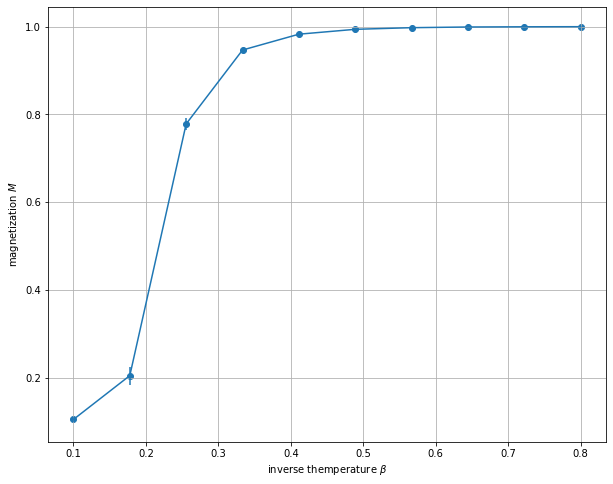

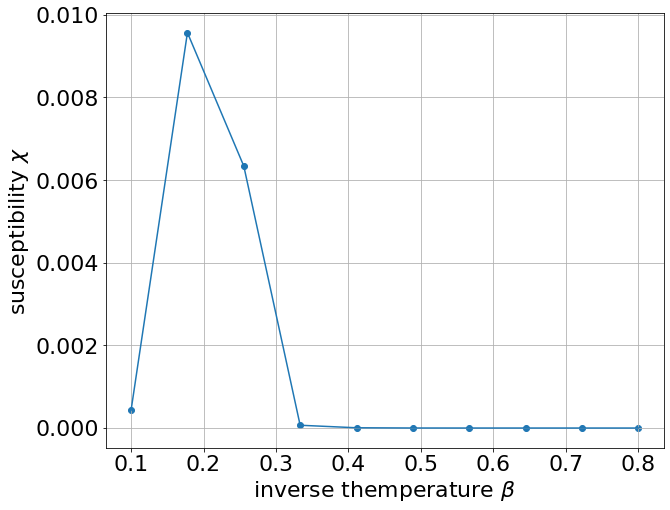

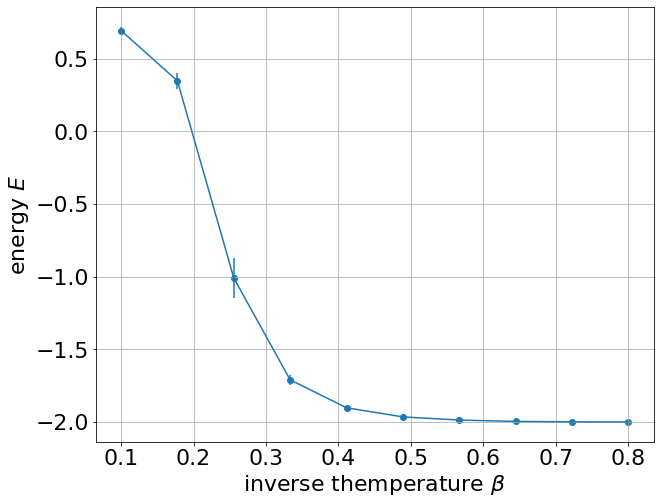

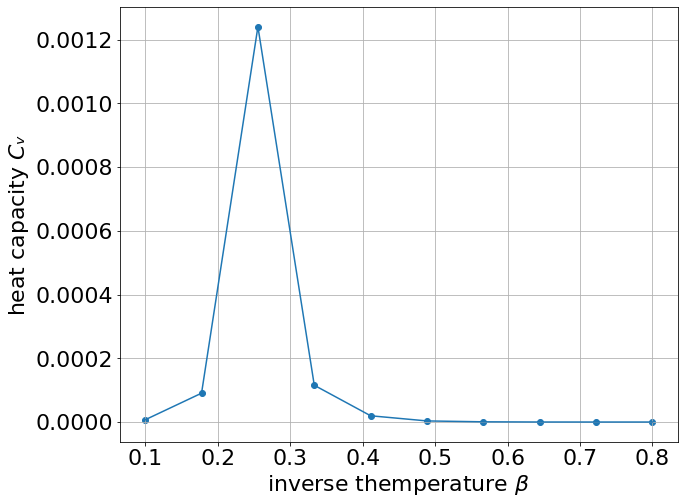

In [16]:
#measure and plot the energy E the magnetization M the susceptibility chi and the heat capacity cv at different temperatures T
L = 5 # linear size of the system
N = L**2
beta = np.linspace(0.1, 0.8, 10) # inverse temperatures
Nthermalization = int(10e5) # number of thermalization steps
Nsample = 5000 # number of samples (= size of the Markov chain)
Nsubsweep = 10*N # number of subsweeps (to generate better samples)

M_arr, E_arr, M_err, E_err, chi_arr, cv_arr = simulate_3d(L,beta,Nthermalization,Nsample,Nsubsweep)

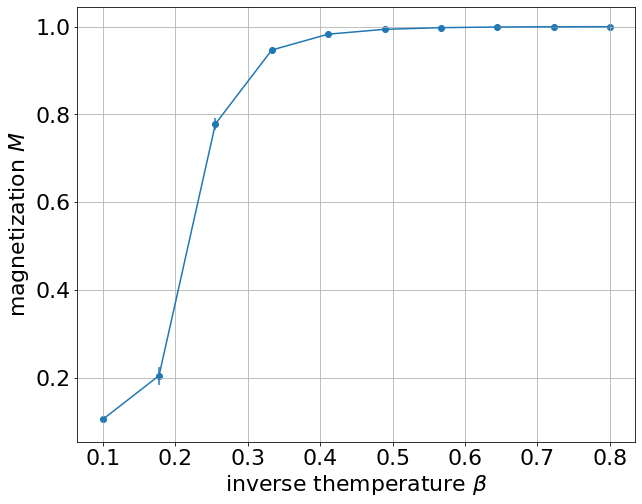

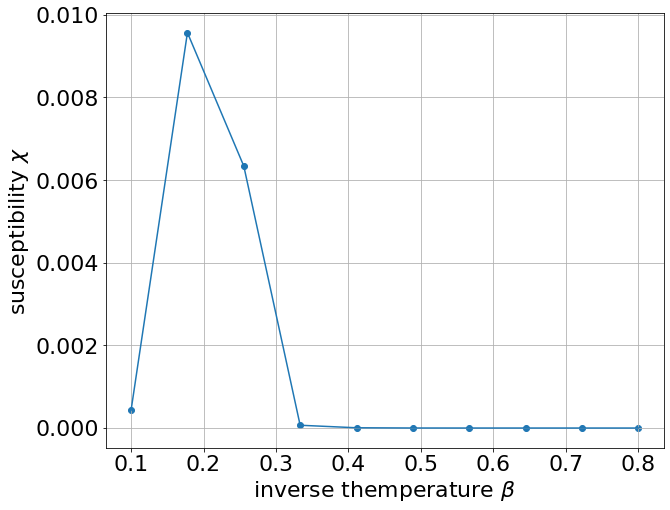

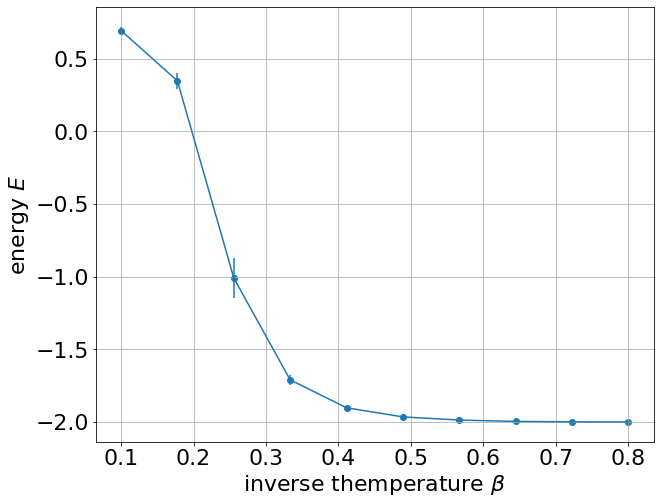

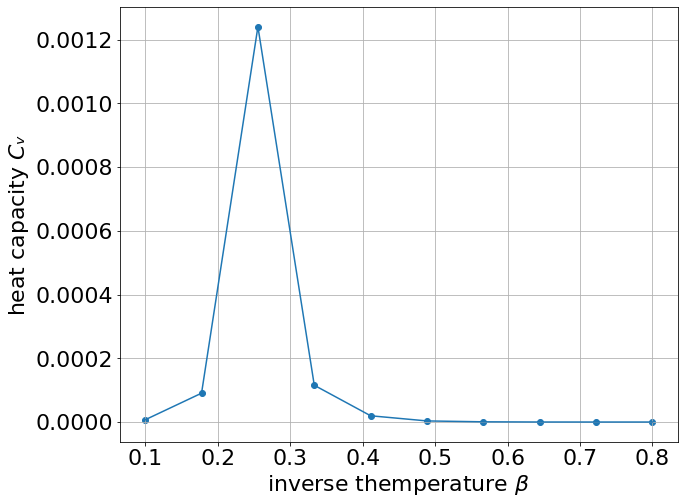

In [17]:
#plot magnetization
plt.figure(figsize=(10,8))
plt.scatter(beta, M_arr)
plt.errorbar(beta, M_arr,yerr = M_err)
plt.xlabel(r"inverse themperature $\beta$")
plt.ylabel(r"magnetization $M$")
plt.grid(True)
plt.rcParams.update({'font.size': 22})
#plt.savefig("magnetization.svg", format = 'svg', dpi=300)

#plot susceptibility
plt.figure(figsize=(10,8))
plt.scatter(beta,chi_arr)
plt.plot(beta,chi_arr)
plt.xlabel(r"inverse themperature $\beta$")
plt.ylabel(r"susceptibility $\chi$")
plt.grid(True)
plt.rcParams.update({'font.size': 22})
#plt.savefig("susceptibility.svg", format = 'svg', dpi=300)

#plot energy
plt.figure(figsize=(10,8))
plt.scatter(beta, E_arr)
plt.errorbar(beta, E_arr, yerr = E_err)
plt.xlabel(r"inverse themperature $\beta$")
plt.ylabel(r"energy $E$")
plt.grid(True)
plt.rcParams.update({'font.size': 22})
#plt.savefig("energy.svg", format = 'svg', dpi=300)

#plot heat capacity
plt.figure(figsize=(10,8))
plt.scatter(beta,cv_arr)
plt.plot(beta,cv_arr)
plt.xlabel(r"inverse themperature $\beta$")
plt.ylabel(r"heat capacity $Cᵥ$")
plt.grid(True)
plt.rcParams.update({'font.size': 22})
#plt.savefig("capacity.svg", format = 'svg', dpi=300)